# Libraries

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings('ignore')

# Dataset

In [106]:
df = pd.read_csv("Housing.csv")  # Replace with the actual path
print("Dataset shape:", df.shape)
print(df.head())
print(df.info())
print(df.describe())


Dataset shape: (545, 13)
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Da

# Data Cleaning and Encoding

In [109]:
# Data cleaning and encoding

binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
for col in binary_cols:
    df[col] = df[col].map({'yes': 1, 'no': 0})

if 'furnishingstatus' in df.columns:
    df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True)

# Feature Engineering

In [115]:
# Feature engineering

df['price_per_sqft'] = df['price'] / df['area']
df['total_rooms'] = df['bedrooms'] + df['bathrooms']

# Remove Outliers

In [118]:
# Remove Outliers

df = df[df['price'] < df['price'].quantile(0.99)]

# Define Features and Target

In [126]:
numeric_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'price_per_sqft', 'total_rooms']
binary_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
furnishing_features = [col for col in df.columns if col.startswith('furnishingstatus_')]

all_features = numeric_features + binary_features + furnishing_features
X = df[all_features]
y = df['price']

# Train-Test Split

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing

In [134]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('bin', 'passthrough', binary_features + furnishing_features)
    ]
)

# Hyperparameter Tuning

In [138]:

model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(loss='huber', random_state=42))
])

param_grid = {
    'regressor__n_estimators': [200, 300],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 4, 'regressor__n_estimators': 300}


# Evaluation

In [145]:

model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(loss='huber', random_state=42))
])

param_grid = {
    'regressor__n_estimators': [200, 300],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("===  Model Performance ===")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2 Score: {r2:.4f}")

baseline_mae = mean_absolute_error(y_test, [y_train.mean()] * len(y_test))
print(f"Baseline MAE (predicting mean): {baseline_mae:.2f}")
print(f"Improvement: {(1 - mae / baseline_mae) * 100:.2f}% over baseline")

Best Parameters: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 4, 'regressor__n_estimators': 300}
===  Model Performance ===
MAE: 153146.95
RMSE: 233972.94
R^2 Score: 0.9857
Baseline MAE (predicting mean): 1569993.65
Improvement: 90.25% over baseline


# Visualization

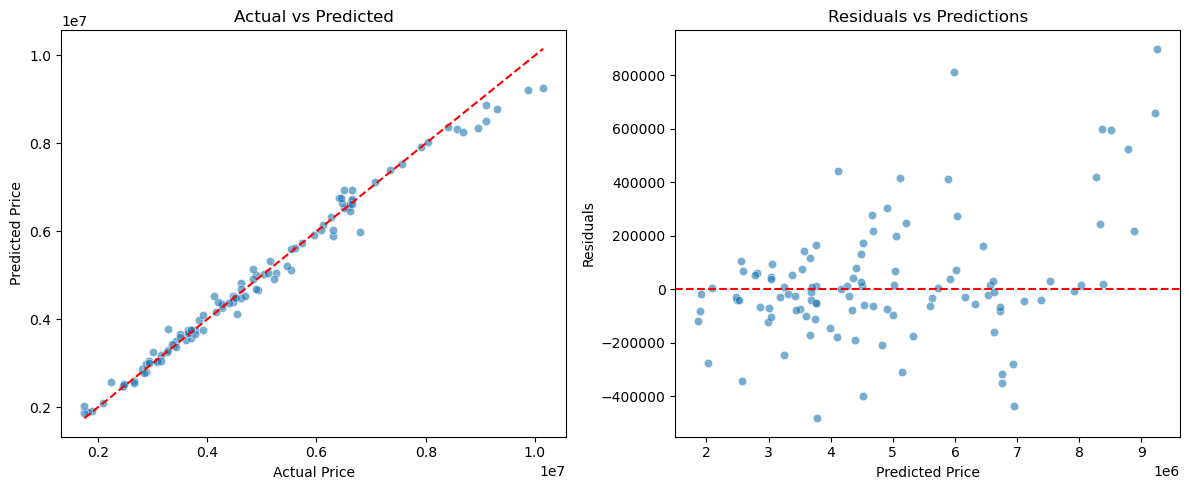

In [150]:
# Visualization

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted")

plt.subplot(1, 2, 2)
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions")

plt.tight_layout()
plt.show()